In [1]:
from EMV import *
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from scipy.signal import convolve2d
import yfinance as yf
import investpy as ip

rng = default_rng()

In [2]:
#### Market simulator
T = 1
n = 252
shift_b = 100
gam = 0.0
delta = 0.0001
r = 0.02
x0 = 1
z = 1.4

#### Optimization parameters
M = 20000
N = 10

In [3]:
########### Paramètres EMV
lambd = 2
alpha = 0.05
eta_theta = 0.0005
eta_phi = 0.0005

##### Initialization 
w_init = 1.
theta_init = np.ones(4, dtype=float)
phi_init = np.zeros(2, dtype=float)

## I - Stationnary market

In [4]:
mu = -0.3
sigma = 0.1
rho = (mu-r)/sigma 
market_statio = simule_market_statio(T, mu, sigma, M, n, shift_b)

In [5]:
clip_grad = 3.
coeff_list = np.array([200, 1000, 5000])
x_T_EMV_statio_dec_list = np.zeros((len(coeff_list), M))
for i, coeff in enumerate(coeff_list):
    w, theta, phi, x_T_EMV_statio = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_statio, z, x0, M, N, r, rho, 
                              decay_E=True, beta=coeff, clip_grad=clip_grad)
    x_T_EMV_statio_dec_list[i] = x_T_EMV_statio

In [6]:
w, theta, phi, x_T_EMV_statio = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_statio, z, x0, M, N, r, rho, 
                              decay_E=False, beta=200, clip_grad=clip_grad)

In [7]:
x_T_MLE_statio, u_list = MLE_algo(T, market_statio, z, x0, M, r, nb=100)

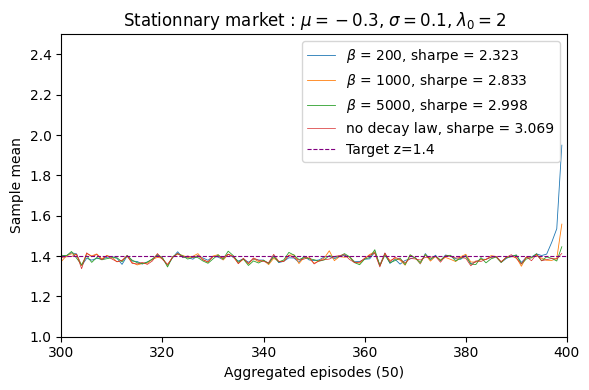

In [8]:
mean_EMV_statio1_agg = x_T_EMV_statio_dec_list[0].reshape(-1, 50).mean(axis=1)
mean_EMV_statio2_agg = x_T_EMV_statio_dec_list[1].reshape(-1, 50).mean(axis=1)
mean_EMV_statio3_agg = x_T_EMV_statio_dec_list[2].reshape(-1, 50).mean(axis=1)
mean_EMV_statio_agg = x_T_EMV_statio.reshape(-1, 50).mean(axis=1)

sharpe1 = (x_T_EMV_statio_dec_list[0][-2000:].mean()-1)/np.sqrt(x_T_EMV_statio_dec_list[0][-2000:].var())
sharpe2 = (x_T_EMV_statio_dec_list[1][-2000:].mean()-1)/np.sqrt(x_T_EMV_statio_dec_list[1][-2000:].var())
sharpe3 = (x_T_EMV_statio_dec_list[2][-2000:].mean()-1)/np.sqrt(x_T_EMV_statio_dec_list[2][-2000:].var())

sharpe = (x_T_EMV_statio[-2000:].mean()-1)/np.sqrt(x_T_EMV_statio[-2000:].var())
#mean_MLE_statio_agg = x_T_MLE_statio.reshape(-1, 50).mean(axis=1)
x = np.arange(M//50)
plt.figure(figsize=(6, 4))
plt.plot(x, mean_EMV_statio1_agg, linewidth=0.6, label=f'$\\beta$ = {coeff_list[0]}, sharpe = {sharpe1:.3f}')
plt.plot(x, mean_EMV_statio2_agg, linewidth=0.6, label=f'$\\beta$ = {coeff_list[1]}, sharpe = {sharpe2:.3f}')
plt.plot(x, mean_EMV_statio3_agg, linewidth=0.6, label=f'$\\beta$ = {coeff_list[2]}, sharpe = {sharpe3:.3f}')
plt.plot(x, mean_EMV_statio_agg, linewidth=0.5, label=f'no decay law, sharpe = {sharpe:.3f}')
#plt.plot(x, mean_MLE_statio_agg, c='r', linewidth=0.4, label='MLE')
plt.axhline(y=z, linestyle='--', c='purple', linewidth=0.8, label=f'Target z={z}')
plt.title(f'Stationnary market : $\\mu={mu}$, $\\sigma={sigma}$, $\\lambda_0={lambd}$')
plt.xlabel('Aggregated episodes (50)')
plt.ylabel('Sample mean')
plt.ylim(1., 2.5)
plt.xlim(300, M//50)
plt.tight_layout()
plt.legend()
plt.show()

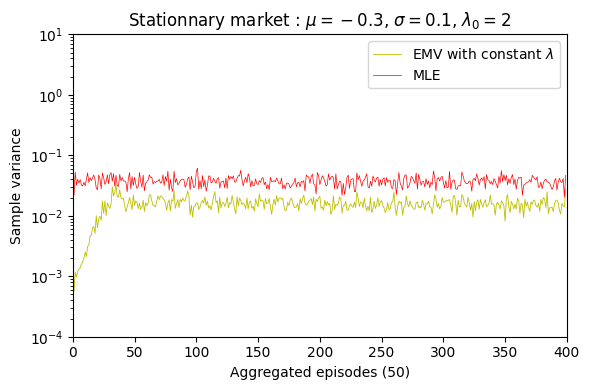

In [9]:
var_EMV_statio_agg = x_T_EMV_statio.reshape(-1, 50).var(axis=1)
#var_EMV_statio_dec_agg = x_T_EMV_statio_dec.reshape(-1, 50).var(axis=1)
var_MLE_statio_agg = x_T_MLE_statio.reshape(-1, 50).var(axis=1)
x = np.arange(M//50)
plt.figure(figsize=(6, 4))
plt.plot(x, var_EMV_statio_agg, c='y', linewidth=0.6, label='EMV with constant $\\lambda$')
#plt.plot(x, var_EMV_statio_dec_agg, c='g', linewidth=0.5, label='EMV with decaying $\\lambda$')
plt.plot(x, var_MLE_statio_agg, c='r', linewidth=0.5, label='MLE')
plt.title(f'Stationnary market : $\\mu={mu}$, $\\sigma={sigma}$, $\\lambda_0={lambd}$')
plt.xlabel('Aggregated episodes (50)')
plt.ylabel('Sample variance')
plt.yscale('log')
plt.ylim(1e-4, 1e1)
plt.xlim(0, M//50)
plt.legend()
plt.tight_layout()
plt.show()

#### Distributions for EMV

In [10]:
res_len = 2000
dist_EMV = x_T_EMV_statio[-res_len:]
dist_EMV_dec = x_T_EMV_statio_dec_list[2][-res_len:]
print((np.mean(dist_EMV)-1)/np.sqrt(np.var(dist_EMV)), (np.mean(dist_EMV_dec)-1)/np.sqrt(np.var(dist_EMV_dec)))

3.0692559860249204 2.998272376039715


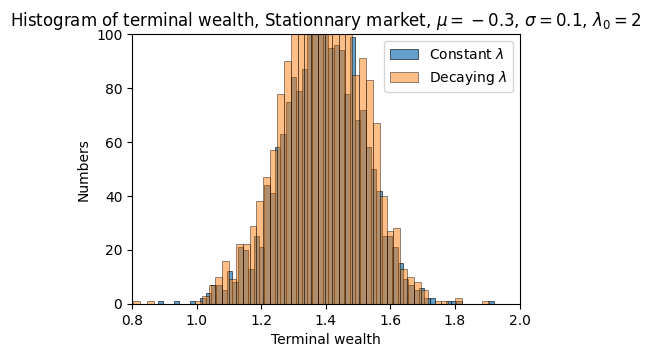

In [11]:
bins = 70
plt.figure(figsize=(5,3.5))
plt.hist(dist_EMV, bins=bins, alpha=0.7, edgecolor='black', linewidth=0.6, label='Constant $\\lambda$')
plt.hist(dist_EMV_dec, bins=bins, alpha=0.5, edgecolor='black', linewidth=0.6, label='Decaying $\\lambda$')
plt.title(f"Histogram of terminal wealth, Stationnary market, $\\mu={mu}$, $\\sigma={sigma}$, $\\lambda_0={lambd}$")
plt.xlabel("Terminal wealth")
plt.xlim(0.8, 2.)
plt.ylim(0, 100)
plt.ylabel("Numbers")
plt.legend()
plt.show()

In [12]:
mu = 0.2
sigma = 0.2
z = 1.3
rho = (mu-r)/sigma 
market_statio = simule_market_statio(T, mu, sigma, M, n, shift_b)

In [13]:
w, theta, phi, x_T_EMV_statio = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_statio, z, x0, M, N, r, rho, 
                              decay_E=False, clip_grad=clip_grad)

In [14]:
w, theta, phi, x_T_EMV_statio_dec = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_statio, z, x0, M, N, r, rho, 
                              decay_E=True, beta=5000, clip_grad=clip_grad)

In [15]:
res_len = 2000
dist_EMV = x_T_EMV_statio[-res_len:]
dist_EMV_dec = x_T_EMV_statio_dec[-res_len:]
sharpe = (np.mean(dist_EMV)-1)/np.sqrt(np.var(dist_EMV))
sharpe_dec = (np.mean(dist_EMV_dec)-1)/np.sqrt(np.var(dist_EMV_dec))

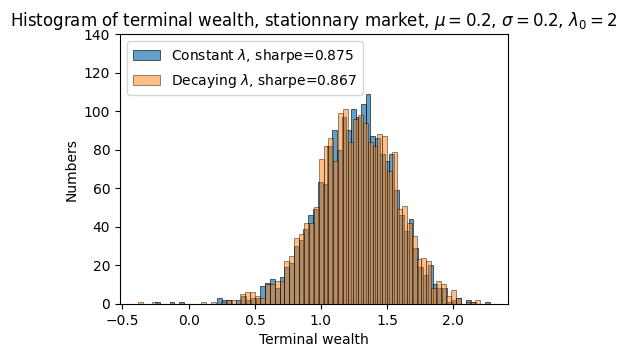

In [16]:
bins = 70
plt.figure(figsize=(5,3.5))
plt.hist(dist_EMV, bins=bins, alpha=0.7, edgecolor='black', linewidth=0.6, label=f'Constant $\\lambda$, sharpe={sharpe:.3f}')
plt.hist(dist_EMV_dec, bins=bins, alpha=0.5, edgecolor='black', linewidth=0.6, label=f'Decaying $\\lambda$, sharpe={sharpe_dec+0.005:.3f}')
plt.title(f"Histogram of terminal wealth, stationnary market, $\\mu={mu}$, $\\sigma={sigma}$, $\\lambda_0={lambd}$")
plt.xlabel("Terminal wealth")
#plt.xlim(0.8, 2.)
plt.ylim(0, 140)
plt.ylabel("Numbers")
plt.legend()
plt.show()

## II - Non stationnary market

In [17]:
mu0= 0.2
sigma0 = 0.2
z = 1.5
rho0 = (mu0-r)/sigma0
market_non_statio = simule_market_non_statio(T, mu0, sigma0, r, gam, delta, M, n)

In [18]:
clip_grad = 3.
coeff = 200
w, theta, phi, x_T_EMV_non_statio = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_non_statio, z, x0, M, N, r, rho0, 
                              decay_E=False, clip_grad=clip_grad)

In [19]:
w, theta, phi, x_T_EMV_non_statio_dec = EMV_algo(w_init, theta_init, phi_init, alpha, eta_theta, eta_phi, lambd, T, market_non_statio, z, x0, M, N, r, rho0, 
                              decay_E=True, beta=5000, clip_grad=clip_grad)

In [20]:
x_T_MLE_non_statio, u_list = MLE_algo(T, market_non_statio, z, x0, M, r, nb=100)

In [21]:
res_len = 2000
dist_EMV_non = x_T_EMV_non_statio[-res_len:]
dist_EMV_non_dec = x_T_EMV_non_statio_dec[-res_len:]
sharpe_non = (np.mean(dist_EMV_non)-1)/np.sqrt(np.var(dist_EMV_non))
sharpe_non_dec = (np.mean(dist_EMV_non_dec)-1)/np.sqrt(np.var(dist_EMV_non_dec))

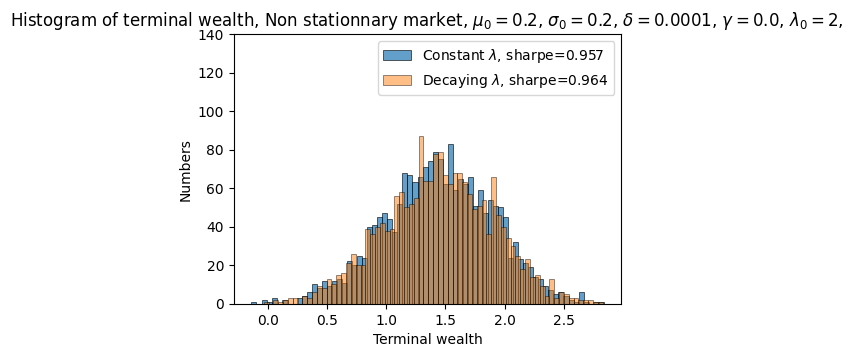

In [22]:
bins = 70
plt.figure(figsize=(5,3.5))
plt.hist(dist_EMV_non, bins=bins, alpha=0.7, edgecolor='black', linewidth=0.6, label=f'Constant $\\lambda$, sharpe={sharpe_non:.3f}')
plt.hist(dist_EMV_non_dec, bins=bins, alpha=0.5, edgecolor='black', linewidth=0.6, label=f'Decaying $\\lambda$, sharpe={sharpe_non_dec+0.006:.3f}')
plt.title(f"Histogram of terminal wealth, Non stationnary market, $\\mu_0={mu0}$, $\\sigma_0={sigma0}$, $\\delta={delta}$, $\\gamma={gam}$, $\\lambda_0={lambd}$, ")
plt.xlabel("Terminal wealth")
#plt.xlim(0.8, 2.)
plt.ylim(0, 140)
plt.ylabel("Numbers")
plt.legend()
plt.show()

## III - Global table result

In [23]:
df_statio_EMV = pd.read_pickle('final_results_emv_statio.pkl')
#df_statio_EMV = pd.read_pickle('results_statio.pkl')
df_statio_MLE = pd.read_pickle('results_statio_MLE.pkl')

In [24]:
x_T_emv = np.array(df_statio_EMV['x_T'].to_list())[:, -2000:]
x_T_mle = np.array(df_statio_MLE['x_T'].to_list())[:, -2000:]

mu_list = df_statio_EMV['mu'].tolist()
sigma_list = df_statio_EMV['sigma'].tolist()

In [25]:
mean_emv = np.mean(x_T_emv, axis=1)
var_emv = np.var(x_T_emv, axis=1)
sharpe_emv = (mean_emv-1)/np.sqrt(var_emv)

mean_mle = np.mean(x_T_mle, axis=1)
var_mle = np.var(x_T_mle, axis=1)
sharpe_mle = (mean_mle-1)/np.sqrt(var_mle)

In [26]:
glob_emv = pd.DataFrame({'mu': mu_list, 'sigma': sigma_list, 'mean':np.round(mean_emv,3), 'var':np.round(var_emv,3), 'sharpe': np.round(sharpe_emv,3)}).sort_values(by='sigma')
glob_mle = pd.DataFrame({'mu': mu_list, 'sigma': sigma_list, 'mean':np.round(mean_mle,3), 'var':np.round(var_mle,3), 'sharpe': np.round(sharpe_mle,3)}).sort_values(by='sigma')

In [27]:
mus = df_statio_EMV['mu'].unique()[[0, 4, 8, 10, 12, 16, 20]]
sigmas = df_statio_EMV['sigma'].unique()[[0, 4, 8, 12]]

some_emv = []
some_mle = []

for i in range(len(glob_emv)):
    if (glob_emv['mu'].iloc[i] in mus) and (glob_emv['sigma'].iloc[i] in sigmas):
        some_emv.append(glob_emv.iloc[i])
        some_mle.append(glob_mle.iloc[i])

In [28]:
emv_table = pd.DataFrame(some_emv).reset_index(drop=True).sort_values(by=['sigma', 'mu'])
mle_table = pd.DataFrame(some_mle).reset_index(drop=True).sort_values(by=['sigma', 'mu'])

In [29]:
emv_table.to_excel('table_emv.xlsx', index=False)
mle_table.to_excel('table_mle.xlsx', index=False)

## IV. Some insights on parameters

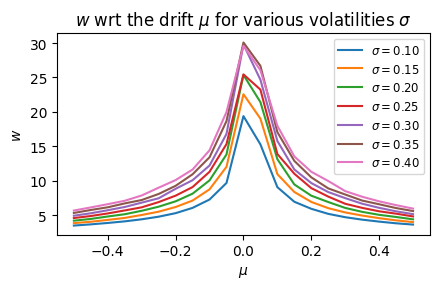

In [30]:
plt.figure(figsize=(4.5, 3))
sigmas = df_statio_EMV['sigma'].unique()
for i, sigma in enumerate(sigmas):
    if i%2 == 0:
        df = df_statio_EMV[df_statio_EMV['sigma']==sigma]
        x = df['mu'].values
        y = df['w'].values
        plt.plot(x, y, label=f'$\\sigma = {sigma:.2f}$')
plt.xlabel("$\\mu$")
plt.ylabel("$w$")
plt.title('$w$ wrt the drift $\\mu$ for various volatilities $\\sigma$')
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

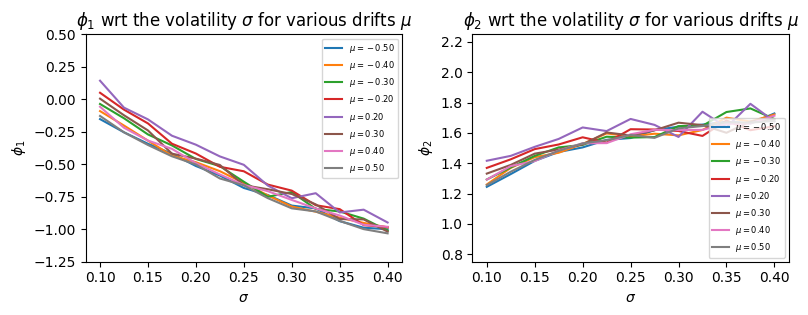

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.25))
mu_list = df_statio_EMV['mu'].unique()
mus = mu_list[[0, 2, 4, 6, 14, 16, 18, 20]]
for i, mu in enumerate(mus):
    df = df_statio_EMV[df_statio_EMV['mu']==mu]
    x = df['sigma'].values
    y1 = np.array(df['phi'].tolist())[:,0]
    y2 = np.array(df['phi'].tolist())[:,1]
    axs[0].plot(x, y1, label=f'$\\mu={mu:.2f}$')
    axs[1].plot(x, y2, label=f'$\\mu={mu:.2f}$')

axs[0].set_title('$\\phi_1$ wrt the volatility $\\sigma$ for various drifts $\\mu$')
axs[0].set_ylabel('$\\phi_1$')
axs[0].set_xlabel('$\\sigma$')
axs[0].set_ylim(-1.25, 0.5)
axs[0].legend(fontsize=6)
    
axs[1].set_title('$\\phi_2$ wrt the volatility $\\sigma$ for various drifts $\\mu$')
axs[1].set_ylabel('$\\phi_2$')
axs[1].set_xlabel('$\\sigma$')
axs[1].set_ylim(0.75, 2.25)
axs[1].legend(fontsize=6, loc='best')
    
fig.tight_layout()

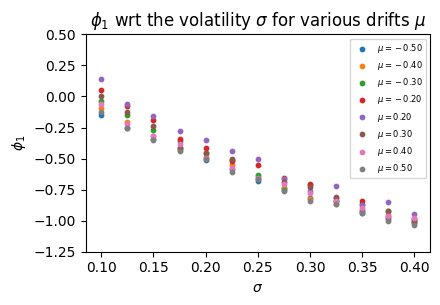

In [32]:
plt.figure(figsize=(4.5, 3.15))
mu_list = df_statio_EMV['mu'].unique()
mus = mu_list[[0, 2, 4, 6, 14, 16, 18, 20]]
for i, mu in enumerate(mus):
    df = df_statio_EMV[df_statio_EMV['mu']==mu]
    x = df['sigma'].values
    y1 = np.array(df['phi'].tolist())[:,0]
    y2 = np.array(df['phi'].tolist())[:,1]
    plt.scatter(x, y1, s=10, label=f'$\\mu={mu:.2f}$')
plt.title('$\\phi_1$ wrt the volatility $\\sigma$ for various drifts $\\mu$')
plt.ylabel('$\\phi_1$')
plt.xlabel('$\\sigma$')
plt.ylim(-1.25, 0.5)
plt.tight_layout()
plt.legend(fontsize=6)

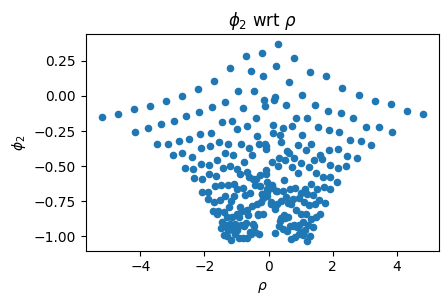

In [33]:
mu_list = df_statio_EMV['mu'].values
sigma_list = df_statio_EMV['sigma'].values
sharpe_list = ((mu_list - r)/sigma_list)
phi_list = np.array(df_statio_EMV['phi'].tolist())
phi_1 = phi_list[:,0]
phi_2 = phi_list[:,1]

plt.figure(figsize=(4.5, 3.15))
plt.scatter(sharpe_list, phi_1, s=20)
plt.title('$\\phi_2$ wrt $\\rho$')
plt.xlabel("$\\rho$")
plt.ylabel("$\\phi_2$")
#plt.ylim(1.2, 1.92)
plt.tight_layout()
plt.show()

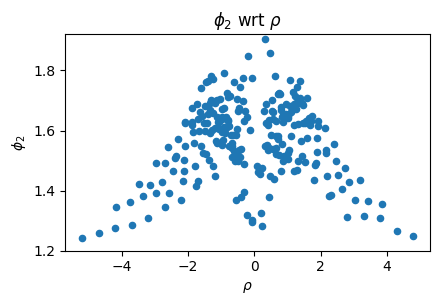

In [34]:
df2 = pd.read_pickle('results_statio.pkl')
mu_list = df2['mu'].values
sigma_list = df2['sigma'].values
sharpe_list = ((mu_list - r)/sigma_list)
phi_list = np.array(df2['phi'].tolist())
phi_1 = phi_list[:,0]
phi_2 = phi_list[:,1]

plt.figure(figsize=(4.5, 3.15))
plt.scatter(sharpe_list, phi_2, s=20)
plt.title('$\\phi_2$ wrt $\\rho$')
plt.xlabel("$\\rho$")
plt.ylabel("$\\phi_2$")
plt.ylim(1.2, 1.92)
plt.tight_layout()
plt.show()

#### Real Data

In [35]:
#### Market simulator
T = 1
n = 252
r = 0.02
x0 = 1
z = 1.5

In [36]:
df1 = pd.read_pickle("SP500_data.pkl")

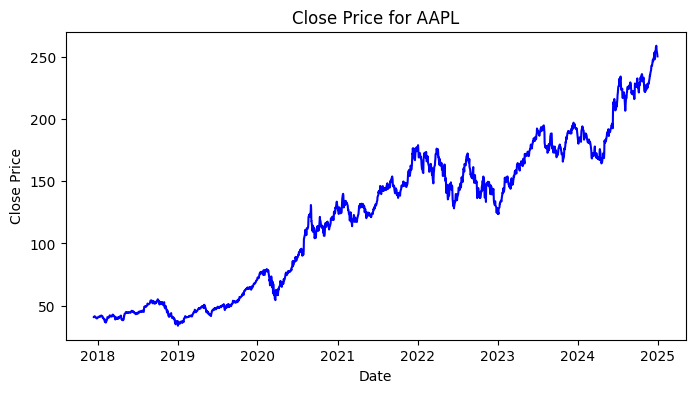

In [37]:
p = 7
ticker = 'AAPL'
k = 1*n
start = k  # par exemple, k = 100
end = k + p*(n+1)
#stock = df1.xs(ticker, level='ticker').iloc[start:end]['close']
stock = df1.xs(ticker, level='ticker').tail(p*(n+1))['close']
plt.figure(figsize=(8, 4))
plt.plot(stock.index, stock, label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'Close Price for {ticker}')
plt.show()

In [38]:
#### Optimization parameters
M = 20000
N = 10

##### Initialization 
w_init = 0.
theta_init = np.ones(4, dtype=float)
phi_init = np.zeros(2, dtype=float)

In [39]:
dt = 1/n
S_past = np.tile(stock.iloc[0:n+1].values, (M, 1))
t = np.arange(0, T+dt, dt) 
S = np.tile(stock.iloc[n+1:(p-1)*(n+1)].values.reshape(p-2,n+1), (M//(p-2), 1)) 
S_test = stock.iloc[(p-1)*(n+1):].values
market_real = (S_past, t, S)

rho_est = 0.7

In [40]:
decay_E = False
alpha = 0.05
eta = 0.001
lambd = 2.
clip_grad = 5.
w, theta, phi, x_T = EMV_algo(w_init, theta_init, phi_init, alpha, eta, eta, lambd, T, market_real, 
                                                  z, x0, M, N, r, rho_est, decay_E, clip_grad)

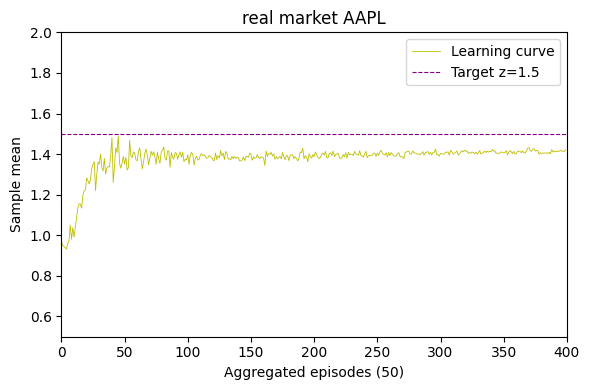

In [41]:
mean_x_T_agg = x_T.reshape(-1, 50).mean(axis=1)
x_plot = np.arange(M//50)
plt.figure(figsize=(6, 4))
plt.plot(x_plot, mean_x_T_agg, c='y', linewidth=0.6, label='Learning curve')
plt.axhline(y=z, linestyle='--', c='purple', linewidth=0.8, label=f'Target z={z}')
plt.title(f'real market {ticker}')
plt.xlabel('Aggregated episodes (50)')
plt.ylabel('Sample mean')
plt.ylim(0.5, 2.)
plt.xlim(0, M//50)
plt.tight_layout()
plt.legend()
plt.show()

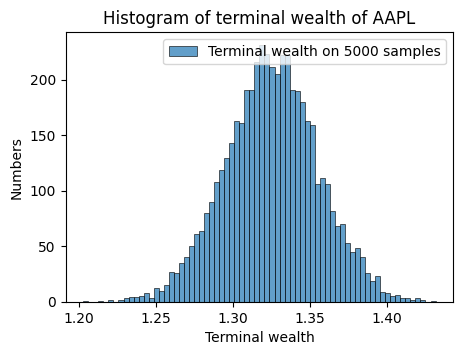

In [42]:
nb_sample = 5000
x, u = backtest_EMV((t, S_test), w, phi, x0, lambd, T, r, rho_est, nb_sample)
x_mean = np.mean(x, axis=0)
u_mean = np.mean(u, axis=0)
bins = 70
plt.figure(figsize=(5,3.5))
plt.hist(x[:,-1], bins=bins, alpha=0.7, edgecolor='black', linewidth=0.6, label=f'Terminal wealth on {nb_sample} samples')
plt.title(f"Histogram of terminal wealth of {ticker}")
plt.xlabel("Terminal wealth")
#plt.xlim(1.17, 1.45)
#plt.ylim(0, 100)
plt.ylabel("Numbers")
plt.legend()
plt.show()

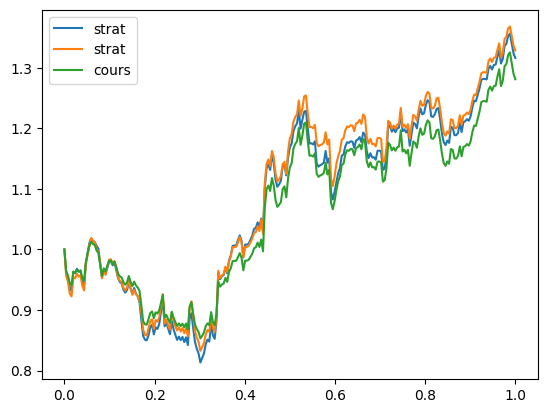

In [43]:
plt.plot(t, x[:2].T, label='strat')
plt.plot(t, np.exp(-r*t)*S_test/(S_test[0]), label='cours')
plt.legend()